# Creating a Need-Based Index for Accessible Health Care

### Authors: Adam Boswell, Hannah Shu, Kyler Shu

---

## **Project Overview**

The goal of this project is to develop a **Need-Based Index** to evaluate and quantify healthcare accessibility across regions. This index leverages key factors such as **income levels**, **hospital size**, **population density**, and **distance to hospitals** to identify areas where healthcare resources are most urgently needed. 

By creating a formulaic representation of healthcare accessibility, this project aims to support equitable distribution of healthcare resources, especially in underserved regions.

In [233]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

<h2>Hospital Dataset</h2>
 This dataset contains number of beds in the hospital



In [ ]:
df_hospitals = pd.read_csv("Data Sets/Hospitals.csv") #read in Hospital data set

<h2>Income Dataset</h2>
 This dataset contains average income of zip code area

In [136]:
df_income = pd.read_csv("Data Sets/income.csv")
df_income = df_income.drop(0) 

#Extracted ZIP code information from the NAME column.
#Assigned population and income data to new columns (pop and income).
#Removed irrelevant columns, leaving only population, income, and ZIP code.

df_income['ZIP'] = df_income['NAME'].str[5:]
df_income['pop'] = df_income['S1903_C01_001E']
df_income['income'] = df_income['S1903_C03_001E']
df_income = df_income[["pop", "income", "ZIP"]]
df_income

C:\Users\kyler\AppData\Local\Temp\ipykernel_24532\1296645527.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,110,111,148,149) have mixed types. Specify dtype option on import or set low_memory=False.
  df_income = pd.read_csv("income.csv")


<h2>Healthcare Access for Zip Codes</h2>
The U.S. Census Bureau's ZIP Code Tabulation Areas (ZCTAs) dataset provides geographic boundaries for ZIP code areas, enabling analysis of demographic, economic, and spatial data for resource allocation, healthcare access, and mapping projects.

In [139]:
gdf_raw = gpd.read_file(r"Data Sets/tl_2020_us_zcta520/tl_2020_us_zcta520.shp")
gdf_raw

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.6539, -88.24713 33.6541..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.3496, -86.81648 34.3496..."
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."
...,...,...,...,...,...,...,...,...,...,...
33786,10540,10540,B5,G6350,S,1394970,27777,+41.3259819,-073.7277119,"POLYGON ((-73.7358 41.33577, -73.73501 41.3358..."
33787,23081,23081,B5,G6350,S,7753698,14654483,+37.1935699,-076.7525080,"POLYGON ((-76.79774 37.21409, -76.79134 37.220..."
33788,23147,23147,B5,G6350,S,143646,0,+37.3696361,-077.0391136,"POLYGON ((-77.04292 37.36996, -77.04143 37.370..."
33789,23298,23298,B5,G6350,S,288664,0,+37.5417074,-077.4295300,"POLYGON ((-77.43284 37.54038, -77.43262 37.540..."


In [140]:
from shapely.geometry import Point

# Step 1: Reproject the GeoDataFrame to a projected CRS
gdf_zipcodes = gdf_raw.to_crs(epsg=3857)

# Step 2: Calculate centroids for all zipcodes
gdf_zipcodes['centroid'] = gdf_zipcodes.geometry.centroid

# Step 3: Merge hospital data with zipcode geometries
# Convert hospital DataFrame to match GeoDataFrame structure
df_hospitals['ZIP'] = df_hospitals['ZIP'].astype(str)
gdf_hospitals = gdf_zipcodes.merge(
    df_hospitals, 
    left_on='GEOID20', 
    right_on='ZIP', 
    how='inner'
)

# Step 4: Create a GeoDataFrame for hospital centroids
gdf_hospitals = gdf_hospitals[['GEOID20', 'centroid']]
gdf_hospitals = gdf_hospitals.set_geometry('centroid')

# Step 5: Perform a spatial join to find nearest hospital centroid for each zipcode centroid
gdf_zipcodes = gdf_zipcodes.set_geometry('centroid')  # Ensure centroids are the active geometry
gdf = gdf_zipcodes.sjoin_nearest(
    gdf_hospitals, 
    how="left", 
    distance_col="distance_to_nearest_hospital"
)

# Step 6: Optional - Save the result to a GeoJSON or CSV
#gdf_zipcodes_with_distances.to_file("zipcode_distances.geojson", driver="GeoJSON")


In [141]:
gdf.rename(columns={"GEOID20_right":"nearest_hospital_zip"})

,ZCTA5CE20,GEOID20_left,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,centroid,index_right,nearest_hospital_zip,distance_to_nearest_hospital
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-9823650.177 3982422.855, -9823625.7...",POINT (-9806880.848 3994369.21),3278,35555,32053.372955
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-9811696.468 4107199.076, -9811694.0...",POINT (-9798219.813 4128370.241),3044,38852,26277.809125
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-9664378.257 4075842.462, -9664366.9...",POINT (-9654062.671 4075855.184),3097,35055,26620.829118
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-9664378.257 4075842.462, -9664366.9...",POINT (-9654062.671 4075855.184),3096,35055,26620.829118
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-9743891.543 4086001.842, -9743886.8...",POINT (-9738279.876 4091083.533),3338,35650,19822.607984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33787,23081,23081,B5,G6350,S,7753698,14654483,+37.1935699,-076.7525080,"POLYGON ((-8549085.311 4468989.914, -8548372.7...",POINT (-8544657.553 4466769.863),1684,23185,8864.448719
33787,23081,23081,B5,G6350,S,7753698,14654483,+37.1935699,-076.7525080,"POLYGON ((-8549085.311 4468989.914, -8548372.7...",POINT (-8544657.553 4466769.863),1683,23185,8864.448719
33788,23147,23147,B5,G6350,S,143646,0,+37.3696361,-077.0391136,"POLYGON ((-8576378.401 4490800.246, -8576212.6...",POINT (-8575954.889 4490755.298),1606,23860,23781.303231
33789,23298,23298,B5,G6350,S,288664,0,+37.5417074,-077.4295300,"POLYGON ((-8619784.876 4514699.413, -8619759.2...",POINT (-8619415.849 4514885.227),2460,23219,605.061715


In [148]:
gdf['ZIP'] = gdf["ZCTA5CE20"].astype(int)
df_income['ZIP'] = df_income['ZIP'].astype(int)

In [149]:
gdf = gdf.merge(df_income, on='ZIP')#, lsuffix='_x', rsuffix='_y')

In [150]:
gdf = gdf.drop_duplicates(subset='ZIP')
gdf = gdf[~((gdf['pop'] == 0) | (gdf['income'] == '-'))]
gdf['income'] = gdf['income'].replace('250,000+', '250000')
gdf['income'] = gdf['income'].replace('2,500-', '2500')
gdf['pop'] = gdf['pop'].astype(int)
gdf['income'] = gdf['income'].astype(int)

In [151]:
df_hospitals['BEDS'] = df_hospitals['BEDS'].apply(lambda x: max(x, 20))

In [152]:
beds = df_hospitals.groupby('ZIP')['BEDS'].sum()
beds

ZIP
10001    1144.0
10003    1119.0
10010      20.0
10011      20.0
10016    1756.0
          ...  
99801      20.0
99833      27.0
99835      54.0
99901      54.0
99929      22.0
Name: BEDS, Length: 5615, dtype: float64

In [153]:
beds_df = beds.reset_index()
beds_df.columns = ['GEOID20_right', 'beds']

# Merge the DataFrame with the beds DataFrame on GEOID20_right (zipcode)
gdf = gdf.merge(beds_df, on='GEOID20_right', how='left')

In [ ]:
pop_serv = gdf.groupby("GEOID20_right")['pop'].sum()
pop_serv_df = pop_serv.reset_index()

,GEOID20_right,pop
0,10001,163985
1,10003,66186
2,10010,16050
3,10011,212852
4,10016,42643
...,...,...
4995,99801,14991
4996,99833,1450
4997,99835,3770
4998,99901,7566


In [157]:
pop_serv_df.columns = ['GEOID20_right', 'pop_serv']

gdf = gdf.merge(pop_serv_df, on='GEOID20_right', how='left')

In [158]:
gdf

,ZCTA5CE20,GEOID20_left,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,centroid,index_right,GEOID20_right,distance_to_nearest_hospital,ZIP,pop,income,beds,pop_serv
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-9823650.177 3982422.855, -9823625.7...",POINT (-9806880.848 3994369.21),3278,35555,32053.372955,35592,1686,41343,61.0,9113
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-9811696.468 4107199.076, -9811694.0...",POINT (-9798219.813 4128370.241),3044,38852,26277.809125,35616,1448,46992,48.0,8995
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-9664378.257 4075842.462, -9664366.9...",POINT (-9654062.671 4075855.184),3097,35055,26620.829118,35621,1052,80938,185.0,45165
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-9743891.543 4086001.842, -9743886.8...",POINT (-9738279.876 4091083.533),3338,35650,19822.607984,35651,461,72552,98.0,9166
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-9568702.383 3721043.169, -9568662.1...",POINT (-9552810.564 3719751.453),3462,36081,32678.801036,36010,2091,39071,97.0,12377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30616,79002,79002,B5,G6350,S,16904752,52999,+35.2044138,-100.7702994,"POLYGON ((-11222595.539 4188862.451, -11222594...",POINT (-11217610.825 4190846.562),6645,79065,46925.669933,79002,15,93750,115.0,9599
30617,78674,78674,B5,G6350,S,926502,2108,+30.6705741,-097.5984811,"POLYGON ((-10865914.866 3590246.188, -10865907...",POINT (-10864408.385 3590239.539),1501,78626,745.231535,78674,56,89500,301.0,32360
30618,78547,78547,B5,G6350,S,4869465,18298,+26.3041868,-098.6964026,"POLYGON ((-10988210.347 3035041.632, -10988195...",POINT (-10986923.944 3037363.359),6781,78582,29094.209843,78547,120,11125,48.0,24309
30619,14557,14557,B5,G6350,S,1928919,0,+43.0434485,-078.0681953,"MULTIPOLYGON (((-8690227.627 5319167.917, -869...",POINT (-8689732.109 5319295.987),2816,14020,18929.365380,14557,41,78750,151.0,24828


In [163]:
gdf['Need Index'] = ((gdf['distance_to_nearest_hospital']+1) * gdf['pop_serv']) / (gdf['income'] * gdf['beds'])

In [219]:
gdf['Need Index'] = gdf['Need Index'].apply(lambda x: 1000 if x > 1000 else x)

<Axes: ylabel='Frequency'>

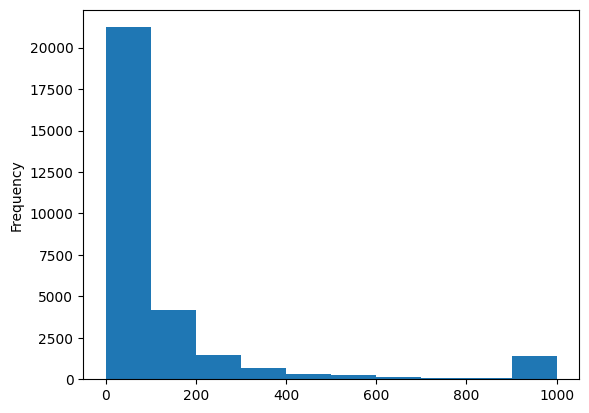

In [221]:
gdf['Need Index'].plot.hist()

In [254]:
bay = pd.read_csv("Bay_Area_ZIP_Codes_20241116.csv")

In [241]:
gdf = gdf.set_geometry('geometry')

In [255]:
gdf[gdf['ZIP'].isin(bay['zip'])]

,ZCTA5CE20,GEOID20_left,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,centroid,index_right,GEOID20_right,distance_to_nearest_hospital,ZIP,pop,income,beds,pop_serv,Need Index
6988,95641,95641,B5,G6350,S,108737211,7179440,+38.1555709,-121.6048157,"POLYGON ((-13546520.153 4596864.583, -13546490...",POINT (-13536752.55 4600704.325),6537,95242,23961.919817,95641,772,52035,24.0,34455,661.127448
7137,94002,94002,B5,G6350,S,14567027,23653,+37.5134466,-122.2968238,"POLYGON ((-13618654.07 4510037.501, -13618597....",POINT (-13614217.132 4510946.908),1758,94403,3541.505089,94002,10854,184929,228.0,68196,5.729669
7138,94402,94402,B5,G6350,S,13087916,0,+37.5401025,-122.3301030,"POLYGON ((-13621490.156 4513383.61, -13621473....",POINT (-13618146.285 4514686.112),1758,94403,3275.719166,94402,10073,184453,228.0,68196,5.313462
7139,94521,94521,B5,G6350,S,25078323,0,+37.9529096,-121.9696955,"POLYGON ((-13582020.05 4575189.391, -13582004....",POINT (-13577604.415 4572776.248),1781,94598,8663.664378,94521,15513,121368,554.0,30594,3.942521
7140,94535,94535,B5,G6350,S,24870031,186948,+38.2709367,-121.9370172,"POLYGON ((-13578263.908 4615943.325, -13578247...",POINT (-13574132.962 4617712.325),6605,94533,7769.253185,94535,1015,79418,132.0,48883,36.232654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29985,94525,94525,B5,G6350,S,6351657,0,+38.0480726,-122.2292077,"POLYGON ((-13609956.567 4585464.454, -13609919...",POINT (-13606493.073 4586219.087),1780,94590,7101.888145,94525,1686,93333,411.0,31532,5.838610
29986,94526,94526,B5,G6350,S,34111007,0,+37.8147341,-121.9845253,"POLYGON ((-13584155.937 4555107.208, -13583808...",POINT (-13579255.729 4553287.883),6539,94583,6011.800856,94526,12174,202697,187.0,25881,4.105527
29993,94528,94528,B5,G6350,S,2988720,0,+37.8414766,-121.9581536,"POLYGON ((-13578253.11 4556713.155, -13578237....",POINT (-13576319.524 4557056.031),1781,94598,7688.561413,94528,230,250000,554.0,30594,1.698588
29994,94531,94531,B5,G6350,S,36331690,0,+37.9566481,-121.7777900,"POLYGON ((-13561389.877 4573178.915, -13561368...",POINT (-13556241.221 4573304.781),6630,94531,0.000000,94531,13233,115300,150.0,55612,0.003215


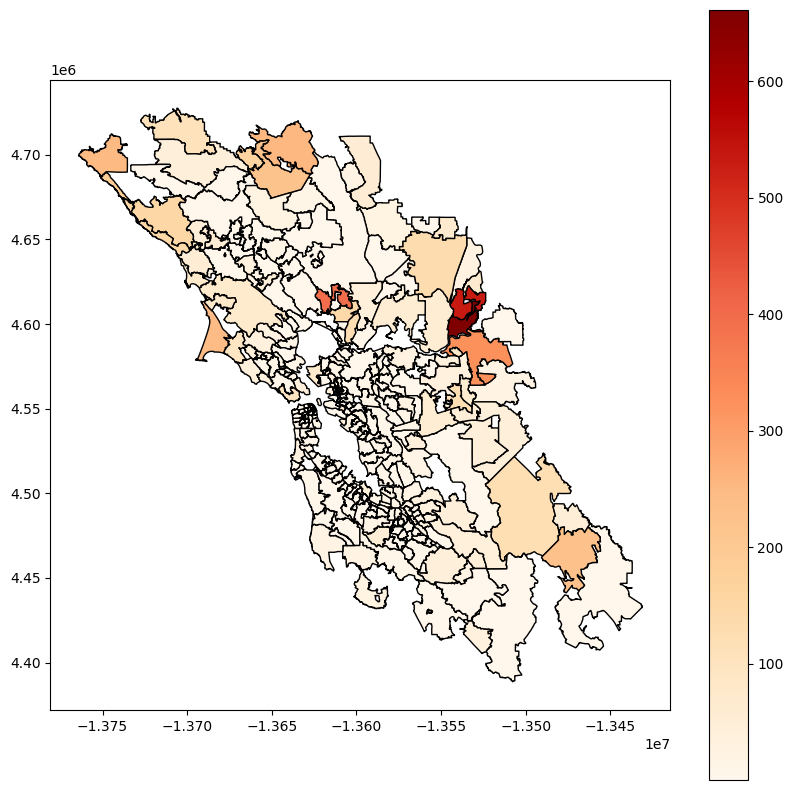

In [256]:
gdf[gdf['ZIP'].isin(bay['zip'])].plot(figsize=(10, 10), edgecolor='black', column = 'Need Index', legend=True, cmap='OrRd')
plt.show()

In [262]:
us = pd.read_csv("uszips.csv")
tx = us[us['state_id'] == 'GA']
tx

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
9760,30002,33.77309,-84.26093,Avondale Estates,GA,Georgia,True,NaN,5856.0,1331.9,13089,DeKalb,"{""13089"": 100}",DeKalb,13089,False,False,America/New_York
9761,30004,34.14352,-84.29926,Alpharetta,GA,Georgia,True,NaN,66406.0,442.5,13121,Fulton,"{""13121"": 68.46, ""13117"": 15.9, ""13057"": 15.64}",Fulton|Forsyth|Cherokee,13121|13117|13057,False,False,America/New_York
9762,30005,34.08582,-84.22158,Alpharetta,GA,Georgia,True,NaN,40260.0,984.4,13121,Fulton,"{""13121"": 70.51, ""13117"": 29.49}",Fulton|Forsyth,13121|13117,False,False,America/New_York
9763,30008,33.89660,-84.58847,Marietta,GA,Georgia,True,NaN,34331.0,1389.2,13067,Cobb,"{""13067"": 100}",Cobb,13067,False,False,America/New_York
9764,30009,34.07711,-84.30290,Alpharetta,GA,Georgia,True,NaN,21281.0,902.2,13121,Fulton,"{""13121"": 100}",Fulton,13121,False,False,America/New_York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13235,39870,31.31944,-84.41071,Newton,GA,Georgia,True,NaN,1865.0,3.9,13007,Baker,"{""13007"": 100}",Baker,13007,False,False,America/New_York
13236,39877,31.91830,-84.50647,Parrott,GA,Georgia,True,NaN,422.0,3.8,13273,Terrell,"{""13273"": 62.88, ""13307"": 37.12}",Terrell|Webster,13273|13307,False,False,America/New_York
13237,39885,31.72189,-84.34304,Sasser,GA,Georgia,True,NaN,19.0,48.5,13273,Terrell,"{""13273"": 100}",Terrell,13273,False,False,America/New_York
13238,39886,31.73469,-84.61554,Shellman,GA,Georgia,True,NaN,1300.0,4.8,13243,Randolph,"{""13243"": 92.83, ""13273"": 4.29, ""13037"": 2.88}",Randolph|Terrell|Calhoun,13243|13273|13037,False,False,America/New_York


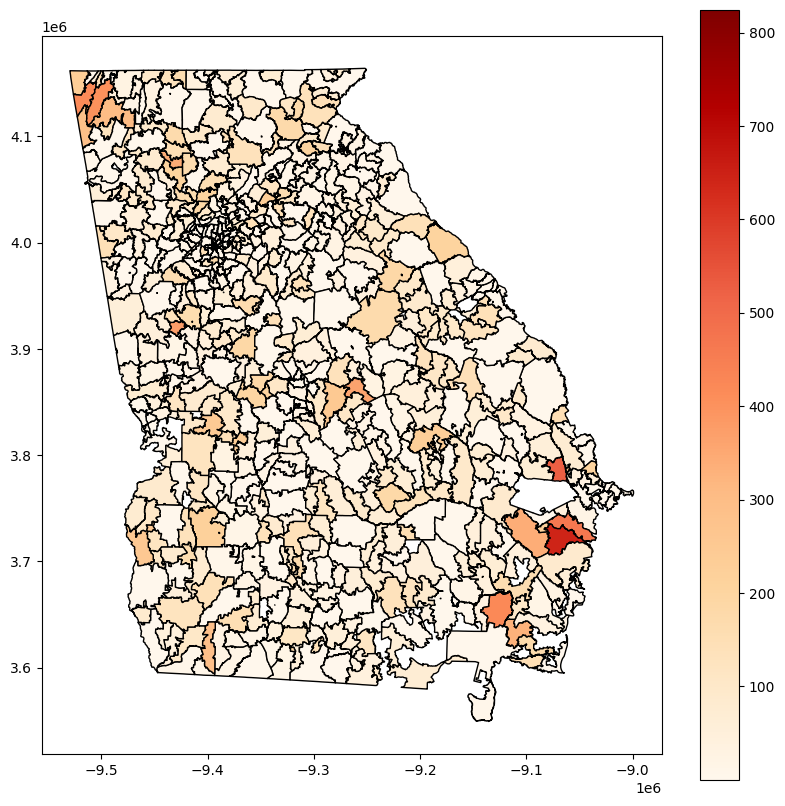

In [263]:
gdf[gdf['ZIP'].isin(tx['zip'])].plot(figsize=(10, 10), edgecolor='black', column = 'Need Index', legend=True, cmap='OrRd')
plt.show()